In [42]:
import sys
import numpy as np
import numpy.linalg as la 
import pandas as pd
from sklearn.preprocessing import normalize
from oct2py import octave
from pandas import DataFrame
from matplotlib import pyplot as plt 
from itertools import permutations, product
import random
import math
from scipy.optimize import linear_sum_assignment as lasum
octave.addpath('~/Github/NSF-Phase1/Blaine/fastica');

In [43]:
def Frobenius_Norm(A, A_):
    return np.sqrt(np.trace(np.subtract(A, A_)@np.subtract(A,A_).conj().T))

In [44]:
def radial_fb(X, val, q): # Set q to be the qth quantile
    return 1 / np.quantile((X.T).dot(val), q)

def compute_polar_fb(X, q, n):
    polar_body = np.ones((n,0))
    for i in range(X.shape[1]):
        if radial_fb(X, X[:,i] / la.norm(X[:,i]), q) >= la.norm(X[:,i]):
            yeet = np.array(X[:,i]).reshape(n,1)
            polar_body = np.hstack((polar_body, yeet))
    return polar_body

def compute_fb(X, q, n):
    Kpol = compute_polar_fb(X, q, n)
    floating_body = np.ones((n,0))
    maxVal = 0
    maxPoint = np.ones((n,0))
    for i in range(X.shape[1]):
        dotValMat = (X[:,i].T).dot(Kpol)
        for j in range(dotValMat.shape[0]):
            if dotValMat[j] > maxVal:
                maxVal = dotValMat[j]        
        if maxVal <= 1:
            maxPoint = np.array(X[:,i]).reshape(n,1)
            floating_body = np.hstack((floating_body, maxPoint))
        maxVal = 0
    return floating_body
def Get_Min(A,A_):
    weights = -abs((A.T@A_)**2)
    ind = octave.munkres(weights)
    print(ind)
    fs = [int(x) - 1 for x in list(ind[0])]
    B = A_[:, fs]
    innerprod = np.diag(np.real(A.T@B) < 0)
    B[:,innerprod] = -B[:, innerprod]
    min_ = Frobenius_Norm(B, A)
    return min_ 
def simplex(n):
    U = np.random.uniform(0,1,n)
    tmp = np.array([0,1])
    Final = np.zeros(n)
    U = np.hstack((U,tmp))
    U = np.sort(U)
    for i in range(1,n+1):
        Final[i-1] = U[i] - U[i-1]
    Final = np.reshape(Final, (n,1))
    return Final

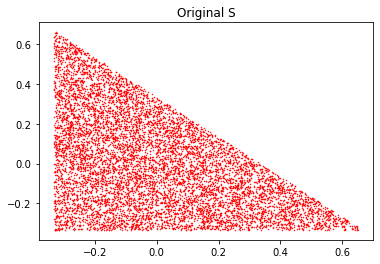

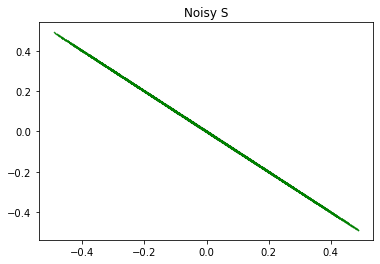

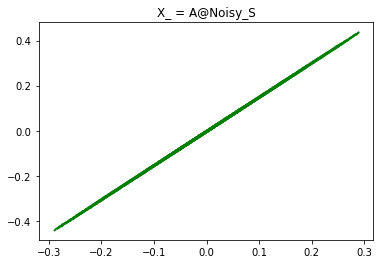

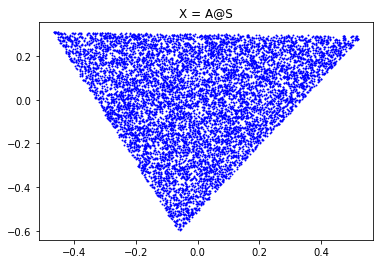

In [56]:
samples = 9000

n = 2
S = np.zeros((n, 1))
p_ = 1
#Uniform samples from the n-dimensional simplex 
for i in range(samples):
    S = np.hstack((S, simplex(n)))
S = np.delete(S, 0,1)
V = np.array([[0,1,0], [0,0,1]]) - np.mean(S)
S = S - np.mean(S)
OG_S = S.copy()
S = np.zeros((n, 1))
for i in range(samples):
    choice = np.random.choice(2, 1, p=[p_, 1-p_])
    if(choice == 0):
        point = simplex(n)
        point -= np.mean(point)
        S = np.hstack((S, point))
    if(choice == 1):
        S = np.hstack((S,np.random.standard_cauchy((n,1))))
        #S = np.hstack((S, np.random.pareto(3,(n,1))))
S = np.delete(S, 0,1)

plt.plot(OG_S[0,:], OG_S[1,:], "or", markersize = 0.5)
plt.title("Original S")
plt.show()

#Plot the now noisy l-1 ball
plt.plot(S[0,:], S[1,:], "og", markersize = 0.5)
plt.title("Noisy S")
plt.show()

A = np.random.normal(0,1,(n,n))

#Computing the repmat
sqrt = np.sqrt(np.sum(A**2, axis = 0))
A = A  / (np.tile(sqrt,(n,1)))
#A = np.array([[1,0],[0,1]])
#ICA Definition (Noisy samples)
X_ = A@S
#ICA definition with original samples 
X = A@OG_S
V = A@V
#Plot Transformed S, and Transformed original samples
plt.plot(X_[0,:], X_[1, :], "og", markersize = .9)
plt.title("X_ = A@Noisy_S")
plt.show()
plt.plot(X[0,:], X[1, :], "ob", markersize = .9)
plt.title("X = A@S")
plt.show()

In [57]:
X_ = np.vstack([X_, np.ones((1,X_.shape[1]))])
T_ = np.random.gamma(X_.shape[0], 1, (1,X_.shape[1]))
Q_ = X_ * np.tile(T_,(X_.shape[0],1))

A_EST = octave.o2pfastica(Q_)
sign = 1 / A_EST[-1,:]
arr = (A_EST) * np.tile(sign,(A_EST.shape[0], 1))
verts = arr[0:-1,:]

X = np.vstack((X, np.ones((1,X.shape[1]))))
T = np.random.gamma(X.shape[0], 1, (1,X.shape[1]))
Q = X * np.tile(T,(X.shape[0],1))
A_EST_OG = octave.o2pfastica(Q)
sign = 1 / A_EST_OG[-1,:]
arr = (A_EST_OG) * np.tile(sign,(A_EST_OG.shape[0], 1))
verts_OG = arr[0:-1,:]

A_EST_fb = octave.o2pfastica(compute_fb(Q,.95,n+1))
sign = 1 / A_EST_fb[-1,:]
arr = (A_EST_fb) * np.tile(sign,(A_EST_fb.shape[0], 1))
verts_fb = arr[0:-1,:]


(3, 8549)


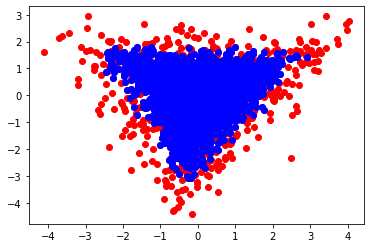

In [58]:
fb = compute_fb(Q,.95,n+1)
print(fb.shape)
#plt.plot(Q_[0,:], Q_[1,:], "go")
plt.plot(Q[0,:], Q[1,:], "ro")
plt.plot(fb[0,:], fb[1,:], "bo")

In [59]:
print(Get_Min(V, verts/la.norm(verts,2)))
print(Get_Min(V, verts_OG/la.norm(verts_OG,2)))
print(Get_Min(V, verts_fb/la.norm(verts_fb,2)))

[[0. 2. 1.]]
0.9437446335320528
[[3. 1. 2.]]
0.3518730701666397
[[3. 1. 2.]]
0.34582213293998904


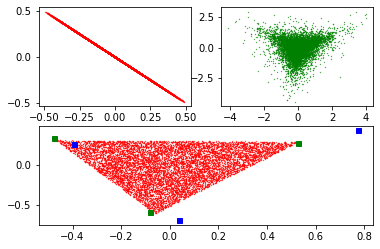

In [60]:
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(2,2,1)
plt.plot(S[0,:], S[1,:], "or", markersize = 0.3)
plt.subplot(2,1,2)
plt.plot(X[0,:], X[1,:], "or", markersize = 0.3)
plt.plot(verts_OG[0,:], verts_OG[1,:], "gs", markersize = 5)
plt.plot(verts_fb[0,:], verts_fb[1,:], "bs", markersize = 5)
plt.subplot(2,2,2)
plt.plot(Q[0,:], Q[1, :], "og", markersize = .3)
plt.show()

In [55]:
verts

array([[ 7.32253968e+02, -6.30583135e+02, -1.09400912e-02],
       [-2.71641909e+03, -9.62415575e+02, -4.99328536e-02]])